# Import

In [2]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.callbacks import History


In [3]:
# https://www.kaggle.com/datasets/jorgesandoval/wind-power-generation
companies = ["50Hertz", "Amprion", "TenneTTSO", "TransnetBW"] 
path = "./data/wind/" 
dataframeHolder = [] 

for comp in companies:
    compPath = path + comp + ".csv" 
    compDF = pd.read_csv(compPath) 
    dataframeHolder.append(compDF) 
    
dataframeHolder[0].head()

,Date,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,...,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00
0,23/08/2019,74,73,63,55,54,53,51,52,45,...,68,68,63,61,57,52,51,49,45,40
1,24/08/2019,37,38,35,35,31,32,30,29,28,...,118,118,112,107,104,104,99,95,95,96
2,25/08/2019,93,88,85,81,76,80,81,76,73,...,111,108,103,96,93,88,86,82,80,77
3,26/08/2019,72,66,59,54,48,46,45,43,42,...,48,47,47,46,47,49,50,51,48,42
4,27/08/2019,39,38,36,36,34,31,31,30,31,...,54,53,51,52,51,52,54,54,56,59


---

# Combine the Dataframes

In [ ]:

def meltComp(compDF, comp):
    df = pd.melt(compDF, id_vars = ["Date"], var_name = "Time", value_name = comp) 
    df["dateTime"] = df["Date"] + " " +df["Time"] 
    df["dateTime"] = pd.to_datetime(df["dateTime"]) 

    df = df.drop(columns = {"Date", "Time"}) 
    df = df.set_index("dateTime")
    df = df.sort_index()
    df.reset_index(drop = False, inplace = True) 
    return df 

In [ ]:
meltDF = []
compIterator = 0 

for compDF in dataframeHolder:
    meltDF.append(meltComp(compDF, companies[compIterator]))
    compIterator += 1

meltDF[0].head() 

/tmp/ipykernel_102596/3518632516.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["dateTime"] = pd.to_datetime(df["dateTime"]) #Turn the datetime column into a datetime type
/tmp/ipykernel_102596/3518632516.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["dateTime"] = pd.to_datetime(df["dateTime"]) #Turn the datetime column into a datetime type
/tmp/ipykernel_102596/3518632516.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["dateTime"] = pd.to_datetime(df["dateTime"]) #Turn the datetime column into a datetime type
/tmp/ipykernel_102596/3518632516.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%

,dateTime,50Hertz
0,2019-08-23 00:00:00,74
1,2019-08-23 00:15:00,73
2,2019-08-23 00:30:00,63
3,2019-08-23 00:45:00,55
4,2019-08-23 01:00:00,54


In [ ]:
mainDF = meltDF[0] 
meltLength = len(meltDF)

for company in range(1, meltLength):
    mainDF = mainDF.merge(meltDF[company], on = "dateTime") 

mainDF = mainDF.set_index("dateTime") 
mainDF = mainDF.asfreq(freq = "15T", fill_value = 0)
mainDF.head()

/tmp/ipykernel_102596/999147856.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  mainDF = mainDF.asfreq(freq = "15T", fill_value = 0) #Set the frequency to every 15 minutes


,50Hertz,Amprion,TenneTTSO,TransnetBW
dateTime,,,,
2019-08-23 00:00:00,74,5,9.68,1.44
2019-08-23 00:15:00,73,5,10.16,1.38
2019-08-23 00:30:00,63,6,10.94,1.38
2019-08-23 00:45:00,55,7,11.39,1.50
2019-08-23 01:00:00,54,6,12.09,1.77


In [ ]:
len(mainDF.index) 

38112

---

# Check for Null Values

In [ ]:
print(mainDF.isnull().any()) 
print(mainDF.describe())

50Hertz       False
Amprion       False
TenneTTSO     False
TransnetBW    False
dtype: bool
            50Hertz       Amprion     TenneTTSO    TransnetBW
count  38112.000000  38112.000000  38112.000000  38112.000000
mean     143.607788     97.769574    146.705854     30.145426
std      138.068975     97.199843    144.065379     35.860767
min        0.000000      0.000000      0.000000      0.000000
25%       43.000000     23.000000     42.287500      5.430000
50%       96.000000     62.000000     93.330000     16.440000
75%      199.000000    144.000000    206.842500     43.815000
max      725.000000    463.000000    727.440000   1506.780000


---

# Vizuelizacija

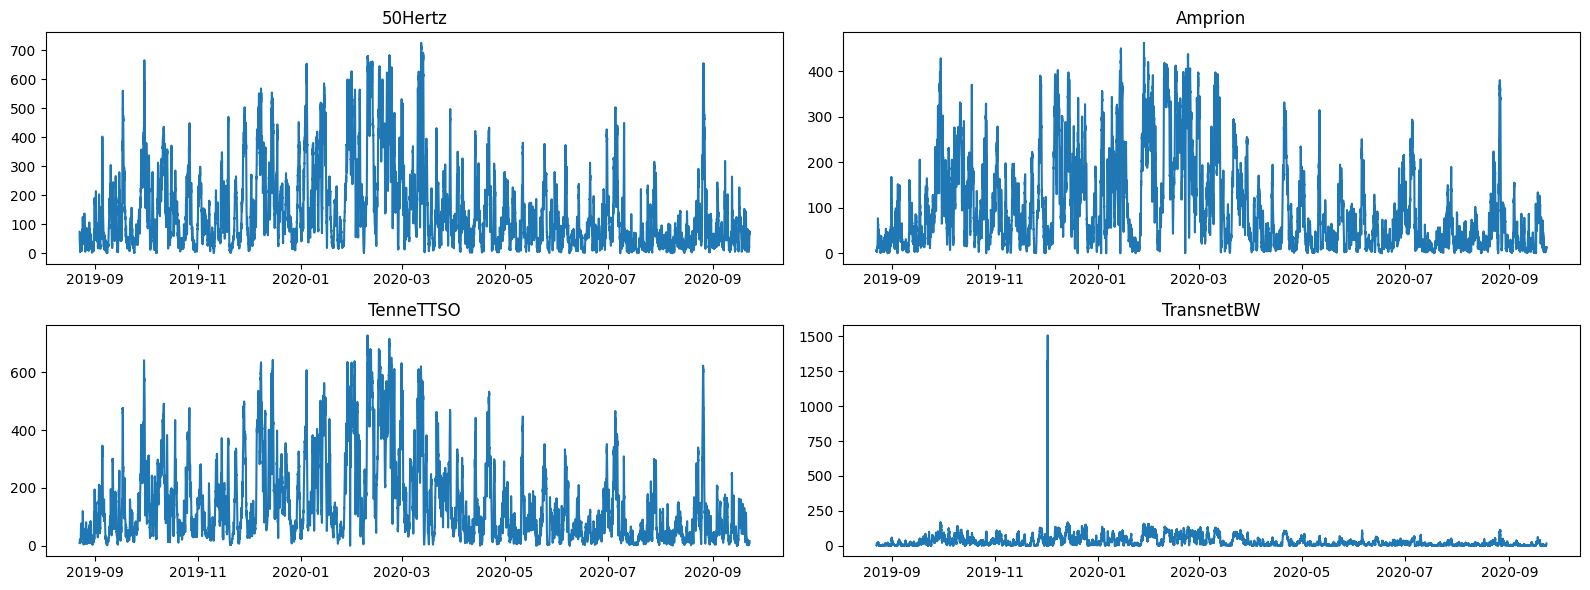

In [9]:

columns = mainDF.columns

plt.figure(figsize=(16, 6))

i  = 0
for col in columns:
    
    plt.subplot(2, 2, i+1)
    plt.plot(mainDF[col])  
    plt.title(col) 
    plt.tight_layout()  

    i+=1
        
plt.show()

In [ ]:
print(mainDF.loc[mainDF["TransnetBW"] > 200]) 

                     50Hertz  Amprion  TenneTTSO  TransnetBW
dateTime                                                    
2019-12-02 08:00:00      130       57     111.22      600.59
2019-12-02 09:00:00      140       56     114.95     1008.15
2019-12-02 10:00:00      154       54     112.71     1324.77
2019-12-02 11:00:00      170       48     109.94     1506.78
2019-12-02 12:00:00      181       41     122.95     1238.06
2019-12-02 13:00:00      195       47     138.67      796.74
2019-12-02 14:00:00      210       41     145.29      287.91


In [ ]:
mainDF.loc[mainDF.index == "2019-03-15 00:15:00"] 

,50Hertz,Amprion,TenneTTSO,TransnetBW
dateTime,,,,


---

In [ ]:
len(mainDF.index)

38112

In [13]:
mainDF

,50Hertz,Amprion,TenneTTSO,TransnetBW
dateTime,,,,
2019-08-23 00:00:00,74,5,9.68,1.44
2019-08-23 00:15:00,73,5,10.16,1.38
2019-08-23 00:30:00,63,6,10.94,1.38
2019-08-23 00:45:00,55,7,11.39,1.50
2019-08-23 01:00:00,54,6,12.09,1.77
...,...,...,...,...
2020-09-22 22:45:00,75,12,11.76,9.78
2020-09-22 23:00:00,72,12,13.18,10.00
2020-09-22 23:15:00,71,13,14.32,11.78


---

# Modeli

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = History()
history1 = History()


## helper function

In [15]:
from sklearn import metrics

results = {}


### print

In [16]:

def print_result(model, model_name, X_test, y_test, end=-1):

    y_pred = model.predict(X_test)

    plt.figure(figsize=(10, 6))

    for i in range(0, len(y_test[0])):
        mean_abs = metrics.mean_absolute_error(y_test[:, i], y_pred[:, i])
        # r2 = metrics.r2_score(y_test[:, i], y_pred[:, i])
        # mean_sqrd = metrics.mean_squared_error(y_test[:, i], y_pred[:, i])

        results[model_name] = [mean_abs]

        plt.subplot(2, 2, i+1)
        plt.plot(y_test[:, i], label='True')   
        plt.plot(y_pred[:, i], label='Predicted') 
        plt.legend()
        plt.tight_layout()  
        
    plt.show()
    


### loss

In [17]:
def plotloss(history):
    plt.figure(figsize=(6, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model's Training & Validation loss across epochs")
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

### split test and train data

In [18]:
def split_into_windows(data, window_size, step_size):
        X, Y = [], []
        for i in range(0, len(data) - window_size, step_size):
            X.append(data.iloc[i:i+window_size])
            Y.append(data.iloc[i+window_size])
        return np.array(X), np.array(Y)

def getTestTrainData(df):

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    print("Train size : ", train_df.shape, "\n"
        "Validation size : ", val_df.shape, "\n"
        "Test Size : ", test_df.shape)

    X_train, Y_train = split_into_windows(train_df.astype(np.float32), 10, 1)
    X_val, Y_val = split_into_windows(val_df.astype(np.float32), 10, 1)
    X_test, Y_test = split_into_windows(test_df.astype(np.float32), 10, 1)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

### make model

In [19]:
def makeModel(X_train, Y_train, X_val, Y_val):
    model = Sequential()
    model.add(SimpleRNN(units = 32, activation = "relu", return_sequences = False, input_shape = (X_train.shape[1],Y_train.shape[1])))
    model.add(Dense(units = 4))
    model.compile(optimizer=Adam(learning_rate=0.001), loss = "mean_squared_error")
    model.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs = 200, batch_size = 32, callbacks=[ history, early_stopping] )

    model1 = Sequential()
    model1.add(LSTM(64, return_sequences = False,  input_shape = (X_train.shape[1],X_train.shape[2])))
    model1.add(Dense(4))
    model1.compile(loss='mse',  optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'] )
    model1.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=150,  callbacks=[history1, early_stopping])

    return model, model1

---

## Initial model

In [20]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = getTestTrainData(mainDF)

Train size :  (26678, 4) 
Validation size :  (7622, 4) 
Test Size :  (3812, 4)


In [21]:
model, model1 = makeModel(X_train, Y_train, X_val, Y_val)

Epoch 1/200
834/834 [==============================] - 3s 3ms/step - loss: 3643.2207 - val_loss: 69.9494
Epoch 2/200
834/834 [==============================] - 2s 3ms/step - loss: 159.7432 - val_loss: 37.7047
Epoch 3/200
834/834 [==============================] - 2s 3ms/step - loss: 110.8701 - val_loss: 31.3079
Epoch 4/200
834/834 [==============================] - 2s 3ms/step - loss: 89.2160 - val_loss: 21.7645
Epoch 5/200
834/834 [==============================] - 2s 3ms/step - loss: 74.6810 - val_loss: 19.6604
Epoch 6/200
834/834 [==============================] - 2s 3ms/step - loss: 75.0101 - val_loss: 16.7166
Epoch 7/200
834/834 [==============================] - 2s 3ms/step - loss: 64.9587 - val_loss: 16.7723
Epoch 8/200
834/834 [==============================] - 2s 3ms/step - loss: 60.2856 - val_loss: 14.8100
Epoch 9/200
834/834 [==============================] - 2s 3ms/step - loss: 61.5835 - val_loss: 14.7093
Epoch 10/200
834/834 [==============================] - 2s 3ms/step -

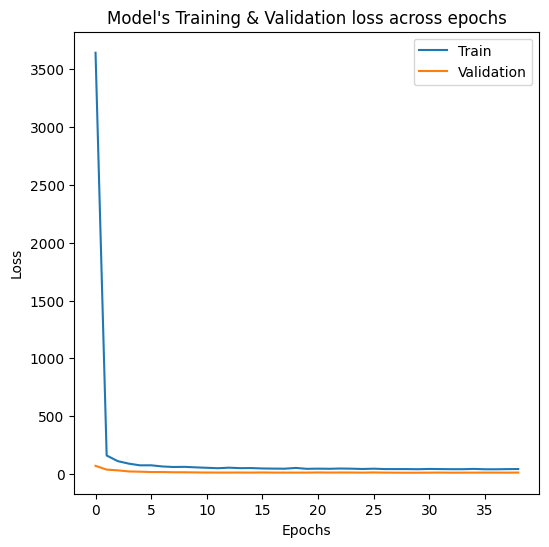

119/119 [==============================] - 0s 2ms/step


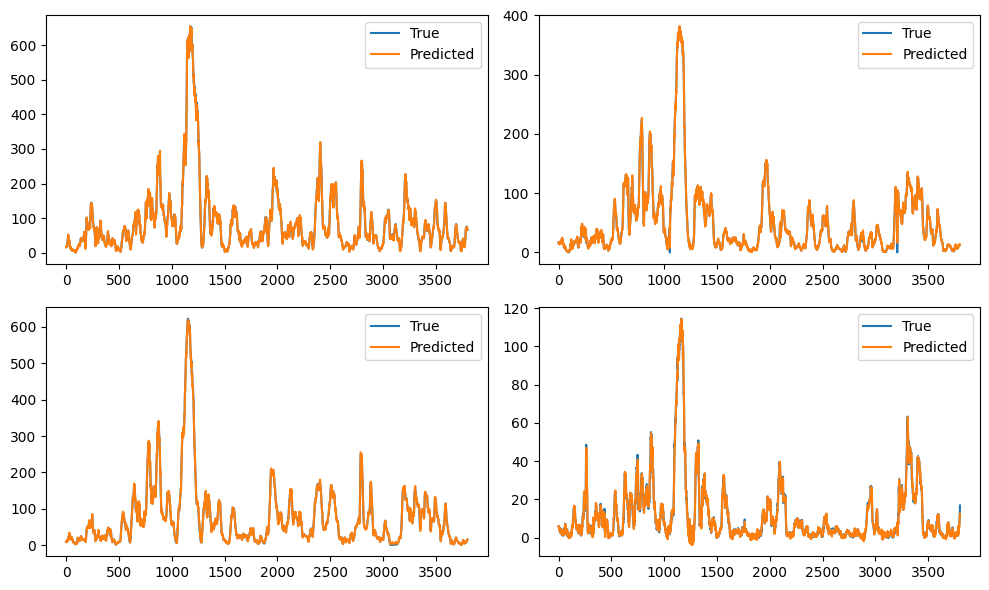

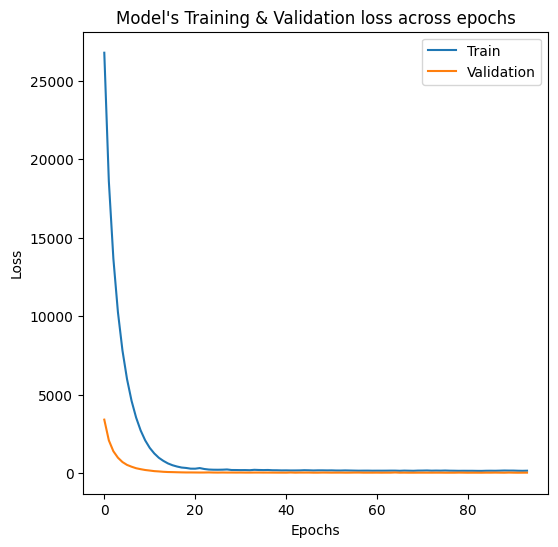

119/119 [==============================] - 1s 2ms/step


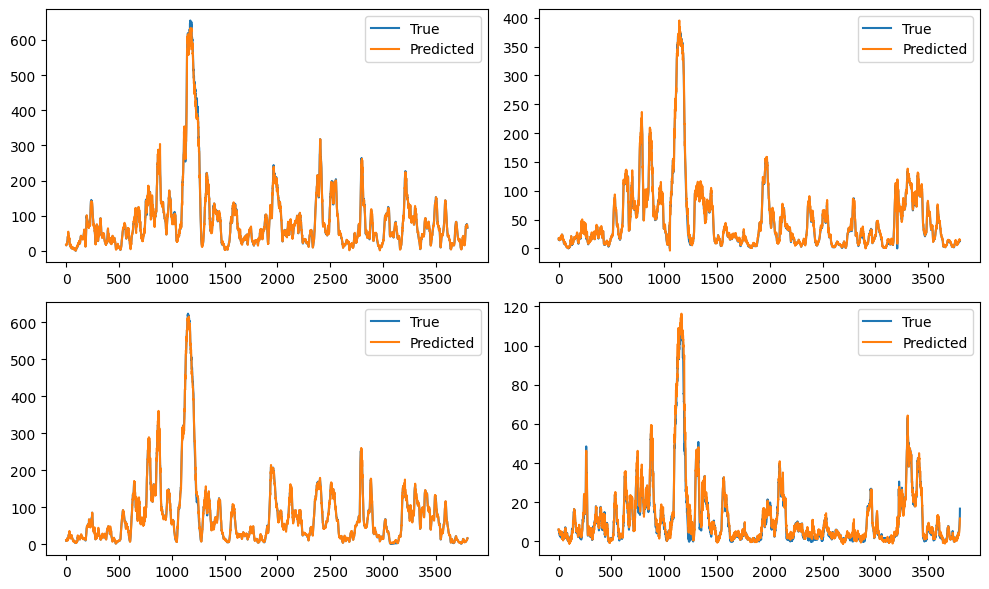

In [22]:

plotloss(history)
print_result(model, 'SimpleRNN', X_test, Y_test, 200)
plotloss(history1)
print_result(model1, 'LSTM', X_test, Y_test, 200)

## PCA

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [ ]:
scaler = StandardScaler()
pca_df = scaler.fit_transform(mainDF)


pca = PCA(n_components=1, random_state=80)
pca.fit(pca_df)  


data_pca = pd.DataFrame(pca.transform(pca_df))

df_reconstructed = pca.inverse_transform(data_pca)

pca_df_denoised = scaler.inverse_transform(df_reconstructed)

In [25]:
pca_df_denoised

array([[32.47263345, 16.81626459, 24.35363967,  4.12619473],
       [32.29175483, 16.68450859, 24.15450466,  4.08384699],
       [30.35462326, 15.27345902, 22.0218551 ,  3.63032105],
       ...,
       [44.81761092, 25.80861977, 37.94461676,  7.01643075],
       [45.46821671, 26.28253545, 38.6608893 ,  7.16875215],
       [48.26964976, 28.32316137, 41.74507576,  7.82463044]])

In [26]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = getTestTrainData(pd.DataFrame(pca_df_denoised))

Train size :  (26678, 4) 
Validation size :  (7622, 4) 
Test Size :  (3812, 4)


In [27]:
model, model1 = makeModel(X_train, Y_train, X_val, Y_val)

Epoch 1/200
834/834 [==============================] - 3s 3ms/step - loss: 1526.9305 - val_loss: 21.2448
Epoch 2/200
834/834 [==============================] - 2s 2ms/step - loss: 134.3777 - val_loss: 13.4713
Epoch 3/200
834/834 [==============================] - 2s 2ms/step - loss: 67.7549 - val_loss: 10.2560
Epoch 4/200
834/834 [==============================] - 2s 2ms/step - loss: 64.9222 - val_loss: 10.6315
Epoch 5/200
834/834 [==============================] - 2s 3ms/step - loss: 53.7543 - val_loss: 10.4338
Epoch 6/200
834/834 [==============================] - 2s 2ms/step - loss: 46.2069 - val_loss: 16.7644
Epoch 7/200
834/834 [==============================] - 2s 2ms/step - loss: 56.8529 - val_loss: 8.3474
Epoch 8/200
834/834 [==============================] - 2s 2ms/step - loss: 36.8434 - val_loss: 10.1663
Epoch 9/200
834/834 [==============================] - 2s 2ms/step - loss: 57.7284 - val_loss: 14.0444
Epoch 10/200
834/834 [==============================] - 2s 2ms/step - l

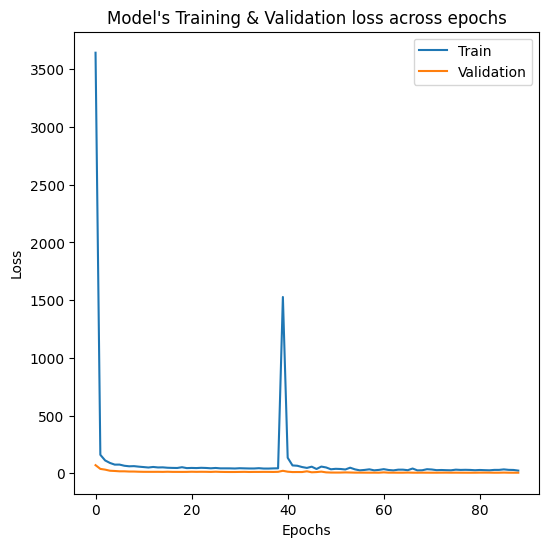

119/119 [==============================] - 0s 1ms/step


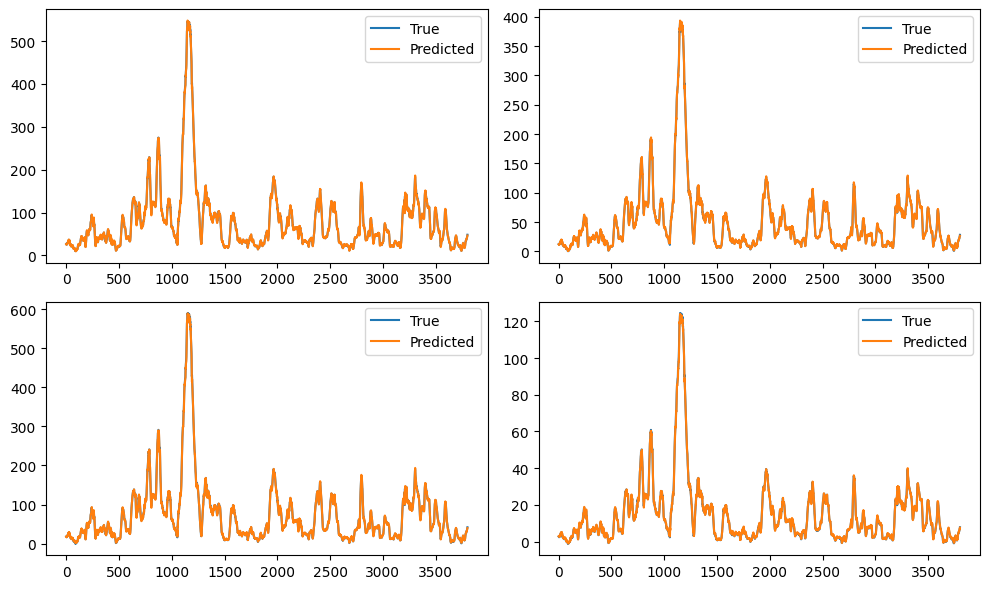

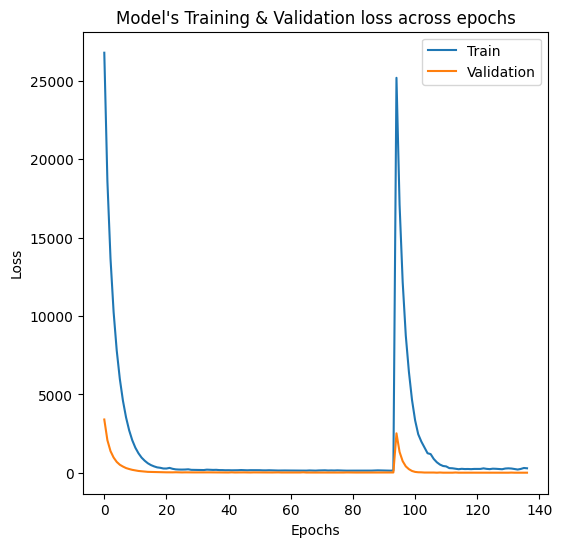

119/119 [==============================] - 1s 2ms/step


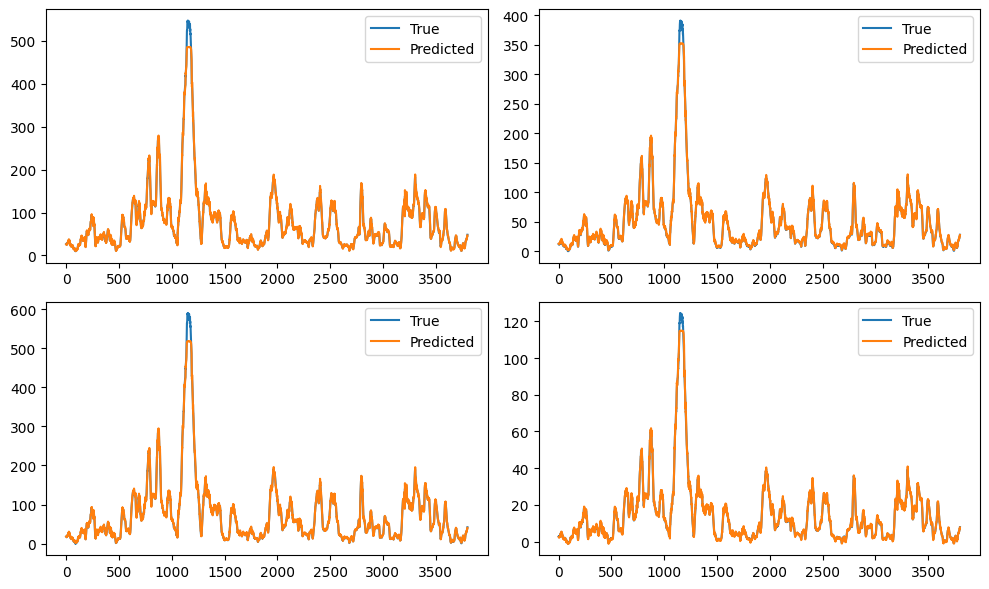

In [28]:
plotloss(history)
print_result(model, 'PCA SimpleRNN', X_test, Y_test, 200)
plotloss(history1)
print_result(model1, 'PCA LSTM', X_test, Y_test, 200)


In [29]:
pd.DataFrame(results, index=["Mean Absolute Error", "R2 Score", "Mean Squared Error"])

,SimpleRNN,LSTM,PCA SimpleRNN,PCA LSTM
Mean Absolute Error,1.100338,1.691534,0.451997,0.558389
R2 Score,1.100338,1.691534,0.451997,0.558389
Mean Squared Error,1.100338,1.691534,0.451997,0.558389


## Autoencoder

In [30]:
from sklearn.preprocessing import MinMaxScaler


In [ ]:
scaler = MinMaxScaler()  
scaled_df = scaler.fit_transform(mainDF)

input_dim = scaled_df.shape[1]
encoding_dim = 4  

autoencoder = Sequential()
autoencoder.add(Dense(encoding_dim, activation='relu', input_shape=(input_dim,)))
autoencoder.add(Dense(input_dim, activation='linear'))
autoencoder.compile(optimizer='adam', loss='mse')  

history = autoencoder.fit(scaled_df, scaled_df, epochs=50, batch_size=128, shuffle=True, validation_split=0.2)

autoencoder_data = autoencoder.predict(scaled_df)

autoencoder_data = scaler.inverse_transform(autoencoder_data)

autoencoder_data


Epoch 1/50
239/239 [==============================] - 1s 2ms/step - loss: 0.0479 - val_loss: 0.0191
Epoch 2/50
239/239 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0022
Epoch 3/50
239/239 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 9.5023e-04
Epoch 4/50
239/239 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 6.4972e-04
Epoch 5/50
239/239 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 4.9162e-04
Epoch 6/50
239/239 [==============================] - 0s 2ms/step - loss: 9.0081e-04 - val_loss: 4.2435e-04
Epoch 7/50
239/239 [==============================] - 0s 1ms/step - loss: 8.2420e-04 - val_loss: 3.8950e-04
Epoch 8/50
239/239 [==============================] - 0s 1ms/step - loss: 7.8645e-04 - val_loss: 3.6137e-04
Epoch 9/50
239/239 [==============================] - 0s 1ms/step - loss: 7.6298e-04 - val_loss: 3.4162e-04
Epoch 10/50
239/239 [==============================] - 0

array([[63.67831   , -0.42399263, 27.76559   ,  4.5511823 ],
       [63.073517  , -0.22314894, 27.55983   ,  4.587151  ],
       [55.256996  ,  1.8906463 , 24.549797  ,  4.93254   ],
       ...,
       [60.86743   ,  7.847117  , 32.14898   ,  6.537311  ],
       [59.751923  ,  8.319659  , 31.843779  ,  6.628962  ],
       [57.506535  ,  8.790118  , 30.879587  ,  6.6942782 ]],
      dtype=float32)

In [32]:
pd.DataFrame(autoencoder_data)

,0,1,2,3
0,63.678310,-0.423993,27.765591,4.551182
1,63.073517,-0.223149,27.559830,4.587151
2,55.256996,1.890646,24.549797,4.932540
3,48.884666,3.722353,22.174809,5.241001
4,48.631222,3.114771,21.585205,5.084594
...,...,...,...,...
38107,63.324112,6.021372,32.249866,6.140856
38108,61.501244,6.627994,31.630627,6.249580
38109,60.867432,7.847117,32.148979,6.537311
38110,59.751923,8.319659,31.843779,6.628962


In [33]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = getTestTrainData(pd.DataFrame(autoencoder_data))


model, model1 = makeModel(X_train, Y_train, X_val, Y_val)


Train size :  (26678, 4) 
Validation size :  (7622, 4) 
Test Size :  (3812, 4)
Epoch 1/200
834/834 [==============================] - 3s 3ms/step - loss: 3611.1519 - val_loss: 24.9086
Epoch 2/200
834/834 [==============================] - 2s 3ms/step - loss: 49.9903 - val_loss: 17.1586
Epoch 3/200
834/834 [==============================] - 2s 3ms/step - loss: 42.2703 - val_loss: 14.2456
Epoch 4/200
834/834 [==============================] - 2s 3ms/step - loss: 37.6762 - val_loss: 11.8360
Epoch 5/200
834/834 [==============================] - 2s 3ms/step - loss: 35.3792 - val_loss: 10.3802
Epoch 6/200
834/834 [==============================] - 2s 3ms/step - loss: 33.4298 - val_loss: 9.4108
Epoch 7/200
834/834 [==============================] - 2s 2ms/step - loss: 31.7210 - val_loss: 10.0491
Epoch 8/200
834/834 [==============================] - 2s 2ms/step - loss: 30.7133 - val_loss: 9.2262
Epoch 9/200
834/834 [==============================] - 2s 2ms/step - loss: 30.1376 - val_loss: 7.

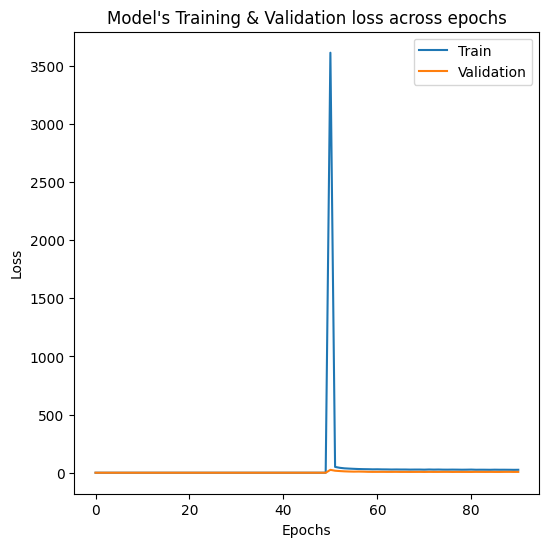

119/119 [==============================] - 0s 1ms/step


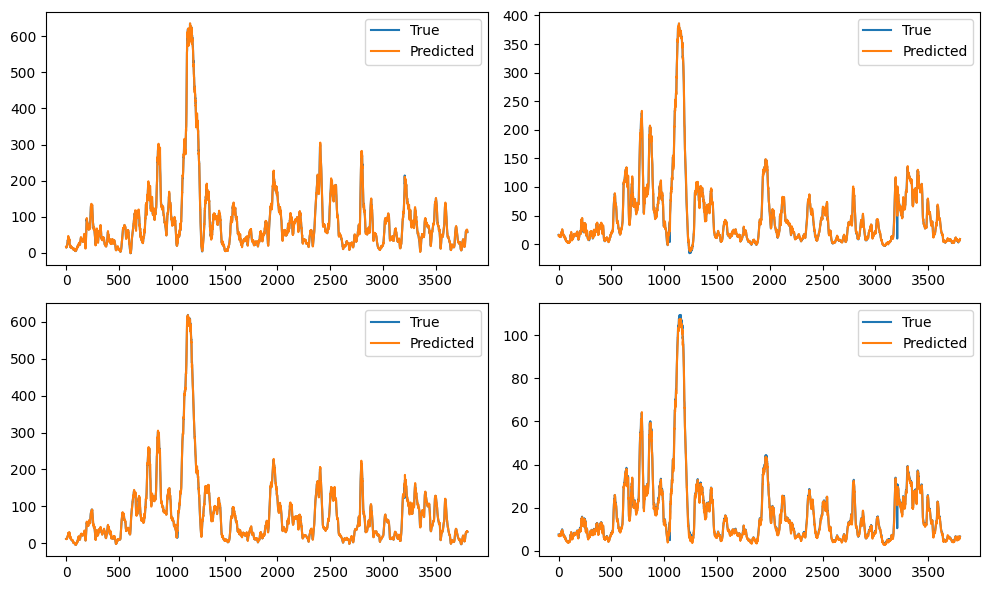

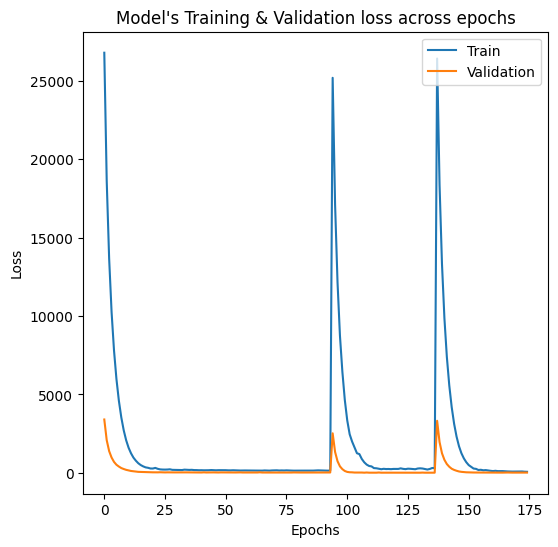

119/119 [==============================] - 1s 2ms/step


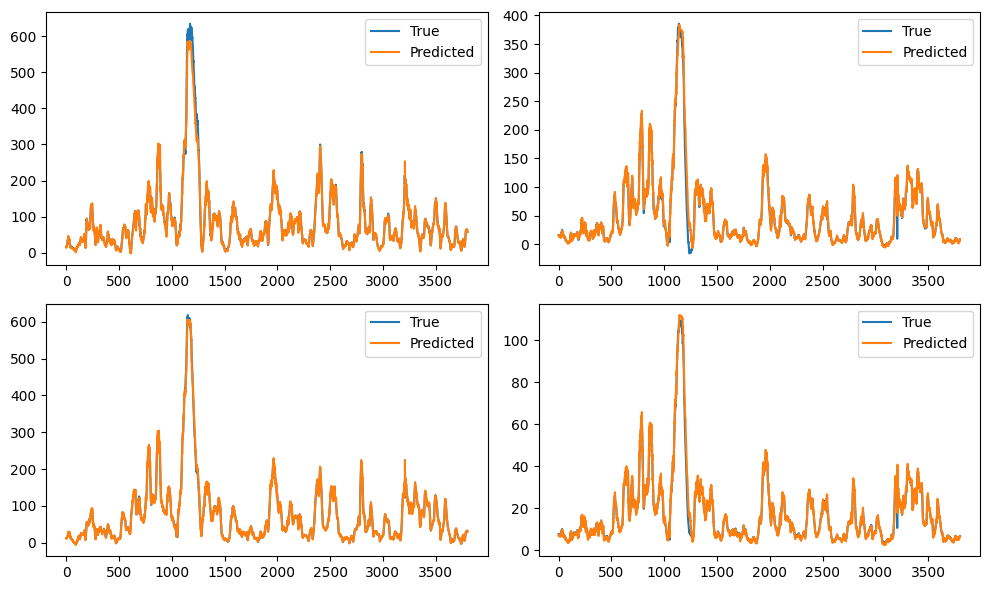

In [34]:


plotloss(history)
print_result(model, 'Encoder SimpleRNN', X_test, Y_test, 200)
plotloss(history1)
print_result(model1, 'Encoder LSTM', X_test, Y_test, 200)


In [35]:
pd.DataFrame(results, index=["Mean Absolute Error"])

,SimpleRNN,LSTM,PCA SimpleRNN,PCA LSTM,Encoder SimpleRNN,Encoder LSTM
Mean Absolute Error,1.100338,1.691534,0.451997,0.558389,0.582834,0.840788


In [36]:
history.history.keys()

dict_keys(['loss', 'val_loss'])